In [7]:
!pip install fasttext numpy scikit-learn pandas tqdm matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 65.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.7/301.7 kB 67.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 83.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 116.5 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python -m pip install --upgrade pip


In [1]:
import pandas as pd
import numpy as np
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score
import fasttext

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load FastText model
ft_model = fasttext.load_model('cc.bn.300.bin')

# Load dataset from CSV file
df = pd.read_csv('final_bn_data.csv', on_bad_lines='skip')
texts = df['content'].values
labels = df['label'].values

# Tokenization and Padding
maxlen = 100
embedding_dim = ft_model.get_dimension()

# Tokenizing the texts into FastText vectors
tokenized_texts = [[ft_model.get_word_vector(w) for w in str(t).split()] for t in texts]
tokenized_texts = [np.pad(np.array(seq)[:maxlen], ((0, maxlen - len(seq[:maxlen])), (0, 0))) for seq in tokenized_texts]

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(np.array(tokenized_texts), np.array(labels), test_size=0.2)

# PyTorch Dataset and DataLoader
class TextDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

train_data = TextDataset(x_train, y_train)
test_data = TextDataset(x_test, y_test)
train_loader = DataLoader(train_data, batch_size=4, shuffle=True)
test_loader = DataLoader(test_data, batch_size=4)

# RNN Model
class RNNModel(torch.nn.Module):
    def __init__(self):
        super(RNNModel, self).__init__()
        self.rnn = torch.nn.LSTM(embedding_dim, 512, batch_first=True)
        self.fc1 = torch.nn.Linear(512, 128)
        self.fc2 = torch.nn.Linear(128, 1)

    def forward(self, x):
        output, _ = self.rnn(x)
        x = output[:, -1, :]
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

model = RNNModel()
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-6)
criterion = torch.nn.BCELoss()


train_losses = []
val_losses = []
accuracies = []
f1_scores = []
precisions = []
recalls = []

true_labels = []
predicted_probs = []

# Training and Validation
for epoch in range(100):
    model.train()
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_x).squeeze(-1)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            outputs = model(batch_x).squeeze()
            val_loss += criterion(outputs, batch_y).item()
            preds = (outputs > 0.5).float()
            correct += (preds == batch_y).float().sum()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())
            true_labels.extend(batch_y.cpu().numpy())
            predicted_probs.extend(outputs.cpu().numpy())

    # Compute additional metrics
    f1 = f1_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)

    train_losses.append(loss.item())
    val_losses.append(val_loss/len(test_loader))
    accuracies.append(correct/len(test_loader.dataset))
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)

    print(f"Epoch {epoch+1}, Training Loss: {loss.item()}, Validation Loss: {val_loss/len(test_loader)}, Validation Acc: {correct/len(test_loader.dataset)}, F1: {f1}, Precision: {precision}, Recall: {recall}")


Using device: cuda:0


Epoch 1, Training Loss: 0.6645182967185974, Validation Loss: 0.6819037360535035, Validation Acc: 0.6980742812156677, F1: 0.8221952207371406, Precision: 0.6980742778541953, Recall: 1.0
Epoch 2, Training Loss: 0.40018028020858765, Validation Loss: 0.6039470574796774, Validation Acc: 0.6980742812156677, F1: 0.8221952207371406, Precision: 0.6980742778541953, Recall: 1.0
Epoch 3, Training Loss: 1.265393853187561, Validation Loss: 0.5999797740451571, Validation Acc: 0.6980742812156677, F1: 0.8221952207371406, Precision: 0.6980742778541953, Recall: 1.0
Epoch 4, Training Loss: 0.31842124462127686, Validation Loss: 0.5994941824240074, Validation Acc: 0.6980742812156677, F1: 0.8221952207371406, Precision: 0.6980742778541953, Recall: 1.0
Epoch 5, Training Loss: 0.3257504403591156, Validation Loss: 0.5956881152468502, Validation Acc: 0.6980742812156677, F1: 0.8221952207371406, Precision: 0.6980742778541953, Recall: 1.0
Epoch 6, Training Loss: 0.3386441767215729, Validation Loss: 0.5936267368567203

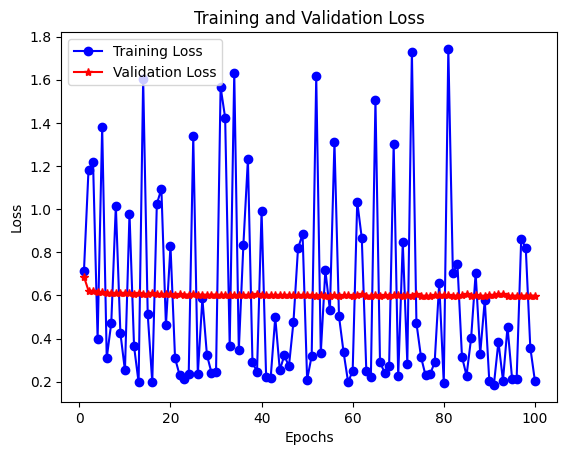

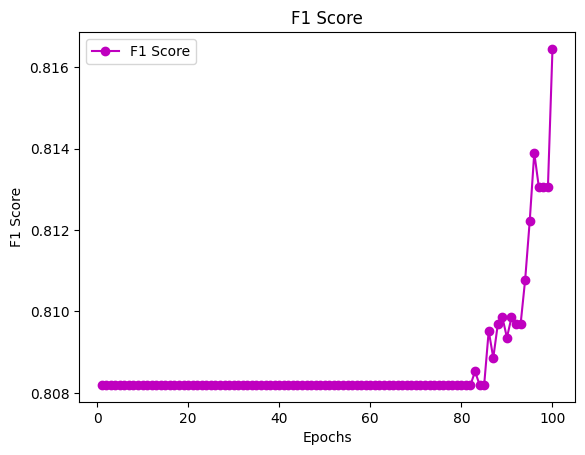

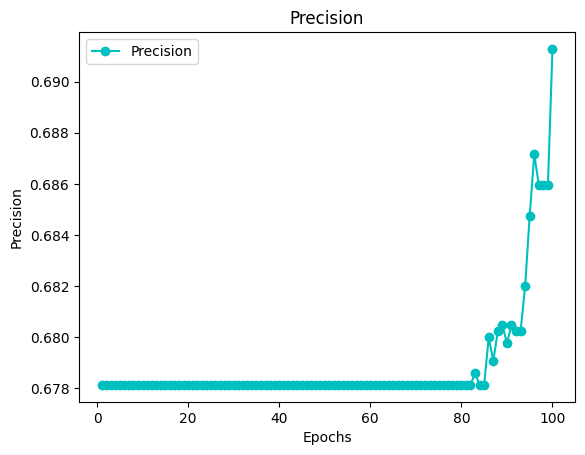

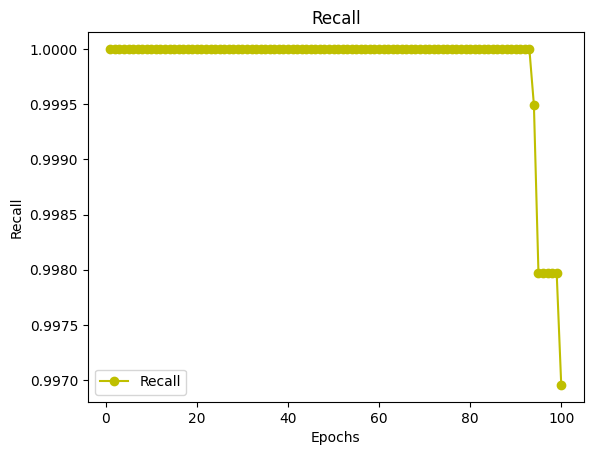

In [2]:
import matplotlib.pyplot as plt

steps = 100
# Generate plots
epochs = range(1, steps + 1)

# Plot for Training and Validation Loss
plt.figure()
plt.plot(epochs, train_losses[0:steps], 'bo-', label='Training Loss')
plt.plot(epochs, val_losses[0:steps], 'r*-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot for Validation Accuracy
# plt.figure()
# plt.plot(epochs, tensor_to_numpy(accuracies), 'go-', label='Validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.title('Validation Accuracy')
# plt.legend()
# plt.show()

# Plot for F1 Score
plt.figure()
plt.plot(epochs, f1_scores[0:steps], 'mo-', label='F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('F1 Score')
plt.legend()
plt.show()

# Plot for Precision
plt.figure()
plt.plot(epochs, precisions[0:steps], 'co-', label='Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.title('Precision')
plt.legend()
plt.show()

# Plot for Recall
plt.figure()
plt.plot(epochs, recalls[0:steps], 'yo-', label='Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.title('Recall')
plt.legend()
plt.show()


In [2]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

fpr, tpr, _ = roc_curve(true_labels, predicted_probs)
roc_auc = auc(fpr, tpr)

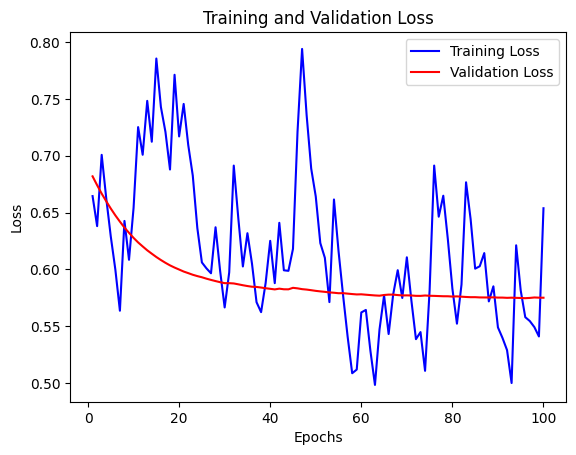

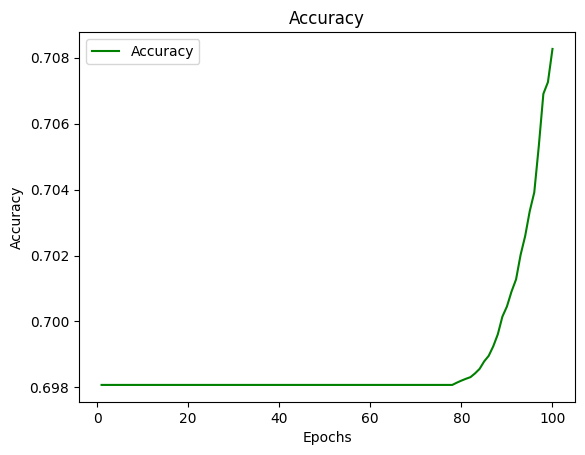

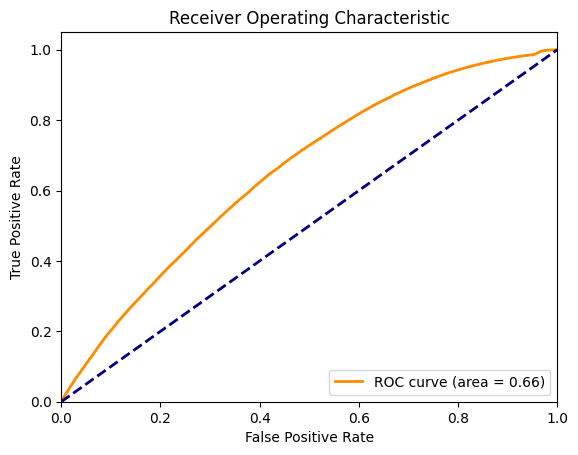

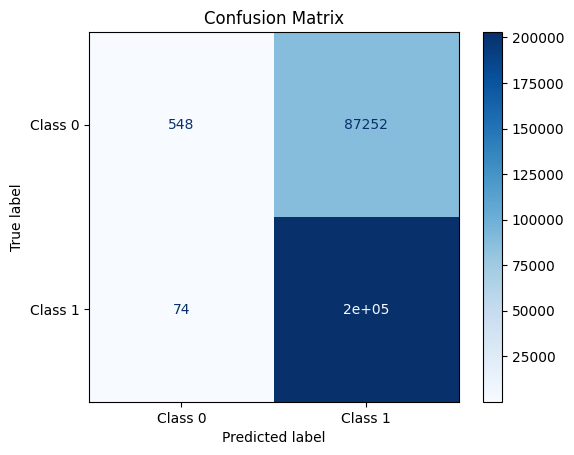

In [3]:
# … [all the previous code remains the same]
import matplotlib.pyplot as plt
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points


# Generate plots
epochs = range(1, len(train_losses) + 1)

# Plot for Training and Validation Loss
plt.figure()
plt.plot(epochs, smooth_curve(train_losses), 'b-', label='Training Loss')
plt.plot(epochs, smooth_curve(val_losses), 'r-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot for Validation Accuracy
plt.figure()
plt.plot(epochs, smooth_curve([accuracy.cpu().item() for accuracy in accuracies]), 'g-', label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

# Plot for F1 Score
# plt.figure()
# plt.plot(epochs, smooth_curve(f1_scores), 'm-', label='Smoothed F1 Score')
# plt.xlabel('Epochs')
# plt.ylabel('F1 Score')
# plt.title('F1 Score')
# plt.legend()
# plt.show()

# # Plot for Precision
# plt.figure()
# plt.plot(epochs, smooth_curve(precisions), 'c-', label='Smoothed Precision')
# plt.xlabel('Epochs')
# plt.ylabel('Precision')
# plt.title('Precision')
# plt.legend()
# plt.show()

# # Plot for Recall
# plt.figure()
# plt.plot(epochs, smooth_curve(recalls), 'y-', label='Smoothed Recall')
# plt.xlabel('Epochs')
# plt.ylabel('Recall')
# plt.title('Recall')
# plt.legend()
# plt.show()

# ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, [1 if prob > 0.5 else 0 for prob in predicted_probs])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()
